# Imports


In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pylab as plt
import os

In [2]:
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, fpmax, fpgrowth, association_rules

# Load data

In [3]:
df = pd.read_csv("data/clicks_sample.csv")

In [11]:
full_df = pd.read_csv("data/full_df.csv.gz", compression="gzip")

In [12]:
full_df.click_timestamp = full_df.click_timestamp.astype(int)

In [13]:
full_df.session_start = full_df.session_start.astype(int)

In [14]:
full_df['session_start_time'] = pd.to_datetime(full_df.session_start, unit="ms")

In [15]:
date = pd.to_datetime(np.min(full_df.session_start), unit="ms")
hour = np.timedelta64(1, 'h')
full_df['hour'] = full_df['session_start_time'].apply(
    lambda x: (date - x) / hour)

In [16]:
full_df['hour'] = np.abs(np.round(full_df['hour']))

In [20]:
full_df = full_df.sort_values("hour")

In [21]:
articles_per_session = []
for session_id, data in df.groupby("session_id"):
    articles_per_session += [list(enumerate(data["click_article_id"].values))]

In [22]:
x = articles_per_session

In [30]:
x[:10]

[[(0, 157541), (1, 68866)],
 [(0, 235840), (1, 96663)],
 [(0, 119592), (1, 30970)],
 [(0, 236065), (1, 236294)],
 [(0, 48915), (1, 44488)],
 [(0, 168868), (1, 207122), (2, 286413)],
 [(0, 202436), (1, 288431)],
 [(0, 235840), (1, 284847)],
 [(0, 332114), (1, 284847), (2, 114161)],
 [(0, 284346), (1, 285412)]]

# Create frequent patterns

In [24]:
def get_article_list(df):
    articles_per_session = []
    for session_id, data in df.groupby("session_id"):
        articles_per_session += [list(enumerate(data["click_article_id"].values))]
    return articles_per_session

In [201]:
def get_frequent_ar(te, x, min_sessions):
    te_ary = te.transform(x)
    data = pd.DataFrame(te_ary, columns=te.columns_)
    frequent_itemsets = fpgrowth(data, min_support=min_sessions/len(x), use_colnames=True)
    ar = association_rules(frequent_itemsets, metric="support", min_threshold=min_sessions/len(x))
    ar["n"] = ar["support"] * len(x)
    return ar

In [202]:
def get_frequent(te, x, min_sessions):
    te_ary = te.transform(x)
    data = pd.DataFrame(te_ary, columns=te.columns_)
    frequent_itemsets = fpgrowth(data, min_support=min_sessions/len(x), use_colnames=True)
    frequent_itemsets["n"] = frequent_itemsets["support"] * len(x)
    return frequent_itemsets

In [203]:
#xx = get_article_list(full_df)

In [204]:
#te = TransactionEncoder()
#te.fit(xx)

TransactionEncoder()

In [205]:
data = full_df.loc[full_df.hour == 42]
freq = get_frequent_ar(te, get_article_list(data), 10)
#freq = freq.loc[(freq.antecedents == frozenset({(0, 199198)})) & (freq.consequents == frozenset({(1, 272143)}))]

In [277]:
def get_by_pos(freq, item):
    freq['items'] = pd.Series(freq["antecedents"].apply(lambda x: list(map(lambda y: y[1], x))))
    freq['pos'] = pd.Series(freq["antecedents"].apply(lambda x: list(map(lambda y: y[0], x))))
    freq['items'].apply(lambda x: x)
    freq["ist"] = freq["items"].apply(lambda x: np.where(np.array(x) == item)[0])
    ddd = freq.loc[freq.ist.apply(lambda x: len(x))>0, ["n","pos", "ist"]]
    ddd["xx"] = freq.loc[freq.ist.apply(lambda x: len(x))>0, ["pos", "ist", "n"]].apply(lambda x: x.iloc[0][x.iloc[1][0]], axis=1)
    if "xx" in list(ddd.columns):
        return list(ddd.groupby("xx").sum().n)
    else: 
        return [0]

In [278]:
def get_pos_by_hour(te, hour, min_sessions, item):
    print(hour)
    data = full_df.loc[full_df.hour == hour]
    freq = get_frequent_ar(te, get_article_list(data), min_sessions)
    return get_by_pos(freq, item)

In [282]:
li = [get_pos_by_hour(te,hour,10, 162655) for hour in range(37, 43)]

37
38
39
40
41
42


In [283]:
li

[[20.0, 29.0, 11.0],
 [491.0, 627.0, 174.0, 20.0],
 [763.0, 621.0, 225.0, 11.0],
 [1113.0, 1219.0, 581.0, 113.0],
 [1407.0, 1076.0, 543.0, 80.0, 13.0],
 [2056.0, 773.0, 309.0, 24.0]]

(0.0, 1.0)

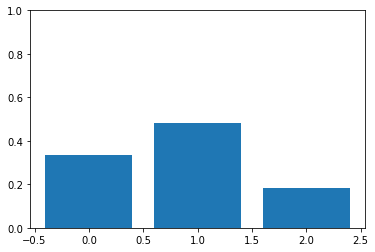

In [284]:
plt.bar(list(range(int(len(li[0])))), np.array(li[0])/sum(li[0]))
plt.ylim([0,1])

(0.0, 1.0)

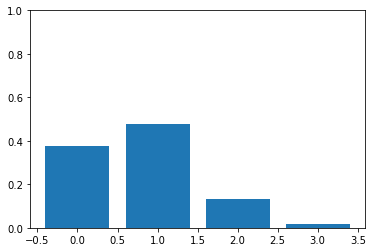

In [285]:
plt.bar(list(range(int(len(li[1])))), np.array(li[1])/sum(li[1]))
plt.ylim([0,1])

(0.0, 1.0)

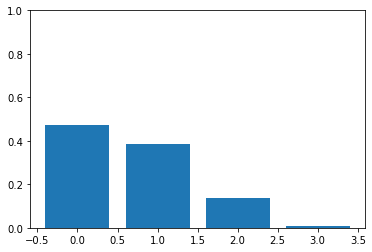

In [286]:
plt.bar(list(range(int(len(li[2])))), np.array(li[2])/sum(li[2]))
plt.ylim([0,1])

(0.0, 1.0)

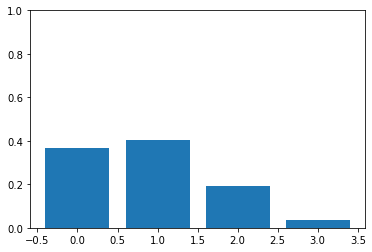

In [287]:
plt.bar(list(range(int(len(li[3])))), np.array(li[3])/sum(li[3]))
plt.ylim([0,1])

(0.0, 1.0)

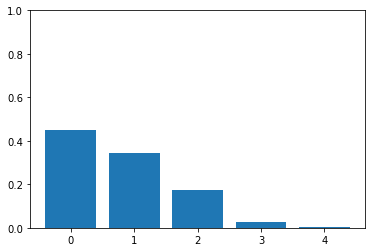

In [288]:
plt.bar(list(range(int(len(li[4])))), np.array(li[4])/sum(li[4]))
plt.ylim([0,1])

(0.0, 1.0)

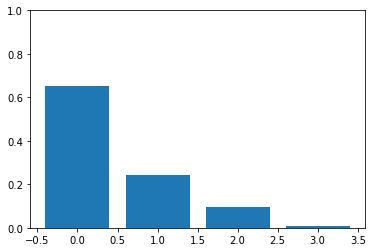

In [290]:
plt.bar(list(range(int(len(li[5])))),  np.array(li[5])/sum(li[5]))
plt.ylim([0,1])

In [ ]:
fitems = lambda x, y: map(lambda z: z[1], x)

In [48]:
def create_time_series(data, a, b, min_sessions):
    points = []
    for hour, data2 in data.groupby("hour"):
        freq = get_frequent_ar(te, get_article_list(data2), 5)
        freq = freq.loc[(freq.antecedents == a) & (freq.consequents == b)]
        if len(freq) > 0:
            points += [((hour, freq.n.values[0]))]
        else:
            points += [((hour, 0))]
        print(points[-1])
    return points

In [204]:
ts = create_time_series(full_df, frozenset({(0, 199198)}), frozenset({(1, 272143)}), 5)

(0.0, 0)
(1.0, 0)
(2.0, 0)
(3.0, 0)
(4.0, 0)
(5.0, 0)
(6.0, 0)
(7.0, 0)
(8.0, 0)
(9.0, 0)
(10.0, 0)
(11.0, 0)
(12.0, 0)
(13.0, 0)
(14.0, 0)
(15.0, 0)
(16.0, 0)
(17.0, 0)
(18.0, 0)
(19.0, 0)
(20.0, 0)
(21.0, 0)
(22.0, 0)
(23.0, 0)
(24.0, 0)
(25.0, 0)
(26.0, 0)
(27.0, 0)
(28.0, 0)
(29.0, 0)
(30.0, 0)
(31.0, 0)
(32.0, 0)
(33.0, 0)
(34.0, 0)
(35.0, 0)
(36.0, 0)
(37.0, 0)
(38.0, 0)
(39.0, 0)
(40.0, 0)
(41.0, 55.0)
(42.0, 183.0)
(43.0, 296.0)
(44.0, 208.0)
(45.0, 181.0)
(46.0, 48.0)
(47.0, 36.0)
(48.0, 23.999999999999996)
(49.0, 12.0)
(50.0, 5.0)
(51.0, 0)
(52.0, 0)
(53.0, 5.0)
(54.0, 14.0)
(55.0, 21.0)
(56.0, 42.0)
(57.0, 92.0)
(58.0, 67.0)
(59.0, 48.0)
(60.0, 8.0)
(61.0, 0)
(62.0, 0)
(63.0, 0)
(64.0, 0)
(65.0, 0)
(66.0, 0)
(67.0, 0)
(68.0, 0)
(69.0, 0)
(70.0, 0)
(71.0, 0)
(72.0, 0)
(73.0, 0)
(74.0, 0)
(75.0, 0)
(76.0, 0)
(77.0, 0)
(78.0, 0)
(79.0, 0)
(80.0, 0)
(81.0, 0)
(82.0, 0)
(83.0, 0)
(84.0, 0)
(85.0, 0)
(86.0, 0)
(87.0, 0)
(88.0, 0)
(89.0, 0)
(90.0, 0)
(91.0, 0)
(92.0, 0)
(93.0, 0)
(

In [ ]:
ts